In [13]:
import torch as ch
import dill
import os
import torchvision

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from robustness import imagenet_models, cifar_models,datasets
from user_constants import DATA_PATH_DICT
import numpy as np

In [14]:
class InputNormalize(ch.nn.Module):
    '''
    A module (custom layer) for normalizing the input to have a fixed 
    mean and standard deviation (user-specified).
    '''
    def __init__(self, new_mean, new_std):
        super(InputNormalize, self).__init__()
        new_std = new_std[..., None, None]
        new_mean = new_mean[..., None, None]

        self.register_buffer("new_mean", new_mean)
        self.register_buffer("new_std", new_std)

    def forward(self, x):
        x = ch.clamp(x, 0, 1)
        x_normalized = (x - self.new_mean)/self.new_std
        return x_normalized
    
class AttackerStep:
    '''
    Generic class for attacker steps, under perturbation constraints
    specified by an "origin input" and a perturbation magnitude. 
    Must implement project, make_step, and random_perturb
    '''
    def __init__(self, orig_input, eps, step_size):
        '''
        Initialize the attacker step with a given perturbation magnitude
        - eps (float): the perturbation magnitude
        - orig_input (ch.tensor): the original input
        '''
        self.orig_input = orig_input 
        self.eps = eps
        self.step_size = step_size

    def project(self, x):
        '''
        Given an input x, project it back into the feasible set
        - x (ch.tensor): the input to project back
        Returns (ch.tensor): the projected input
        '''
        raise NotImplementedError

    def make_step(self, g):
        '''
        Given a gradient, make the appropriate step according to the
        perturbation constraint (e.g. dual norm maximization for lp norms).
        - g (ch.tensor): the raw gradient
        Returns (ch.tensor): the new input
        '''
        raise NotImplementedError

    def random_perturb(self, x):
        '''
        Given a starting input, take a random step within the feasible set
        '''
        raise NotImplementedError

### Instantiations of the AttackerStep class

# L-infinity threat model
class LinfStep(AttackerStep):
    def project(self, x):
        diff = x - self.orig_input
        diff = ch.clamp(diff, -self.eps, self.eps)
        return diff + self.orig_input

    def make_step(self, g):
        step = ch.sign(g) * self.step_size
        return step

    def random_perturb(self, x):
         return 2 * (ch.rand_like(x) - 0.5) * self.eps

# L2 threat model
class L2Step(AttackerStep):
    def project(self, x):
        diff = x - self.orig_input
        diff = diff.renorm(p=2, dim=0, maxnorm=self.eps)
        return self.orig_input + diff

    def make_step(self, g):
        # Scale g so that each element of the batch is at least norm 1
        g_norm = ch.norm(g.view(g.shape[0], -1), dim=1).view(-1, 1, 1, 1)
        scaled_g = g / (g_norm + 1e-10)
        return scaled_g * self.step_size

    def random_perturb(self, x):
        return (ch.rand_like(x) - 0.5).renorm(p=2, dim=1, maxnorm=self.eps)

# Unconstrained threat model
class UnconstrainedStep(AttackerStep):
    def project(self, x):
        return x

    def make_step(self, g):
        return g * self.step_size

    def random_perturb(self, x):
        return (ch.rand_like(x) - 0.5).renorm(p=2, dim=1, maxnorm=step_size)

In [15]:
STEPS = {
    'inf': LinfStep,
    '2': L2Step,
    'unconstrained': UnconstrainedStep
}

class Attacker(ch.nn.Module):
    """
    Attacker (INTERNAL CLASS)
    Attacker class, used to make adversarial examples. 
    This is primarily an internal class, you probably want to be looking at
    AttackerModel, which is how models are actually served (AttackerModel
    uses Attacker).
    """
    def __init__(self, model, dataset):
        """
        Initialize the Attacker 
        - model (PyTorch model [nn.Module]) -- the model to attack
        - dataset (a Dataset class [see datasets.py]) -- only used to get mean and std for normalization
        """
        super(Attacker, self).__init__()
        self.normalize = InputNormalize(dataset.mean, dataset.std)
        self.model = model

    def forward(self, x, target, *_, constraint, eps, step_size, iterations,
                random_start=False, random_restarts=False, do_tqdm=False,
                targeted=False, custom_loss=None, should_normalize=True, 
                orig_input=None, use_best=True):
        """
        Implementation of forward (finds adversarial examples)
        - x (ch.tensor): original input
        - See below (AttackerModel forward) for description of named arguments
        Returns: adversarial example for x
        """
        
        # Can provide a different input to make the feasible set around
        # instead of the initial point
        if orig_input is None: orig_input = x.detach()
        orig_input = orig_input.cuda()

        # Multiplier for gradient ascent [untargeted] or descent [targeted]
        m = -1 if targeted else 1

        # Initialize step class
        step = STEPS[constraint](eps=eps, orig_input=orig_input, step_size=step_size)

        def calc_loss(inp, target):
            '''
            Calculates the loss of an input with respect to target labels
            Uses custom loss (if provided) otherwise the criterion
            '''
            if should_normalize:
                inp = self.normalize(inp)
            output = self.model(inp)
            if custom_loss:
                return custom_loss(self.model, inp, target)

#             return criterion(output, target), output

        # Main function for making adversarial examples
        def get_adv_examples(x):
            # Random start (to escape certain types of gradient masking)
            if random_start:
                x = ch.clamp(x + step.random_perturb(x), 0, 1)

            iterator = range(iterations)
            if do_tqdm: iterator = tqdm(iterator)

            # Keep track of the "best" (worst-case) loss and its
            # corresponding input
            best_loss = None
            best_x = None

            # A function that updates the best loss and best input
            def replace_best(loss, bloss, x, bx):
                if bloss is None:
                    bx = x.clone().detach()
                    bloss = losses.clone().detach()
                else:
                    replace = m * bloss < m * loss
                    bx[replace] = x[replace].clone().detach()
                    bloss[replace] = loss[replace]

                return bloss, bx

            # PGD iterates    
            for _ in iterator:
                x = x.clone().detach().requires_grad_(True)
                losses, out = calc_loss(x, target)
                assert losses.shape[0] == x.shape[0], 'Shape of losses must match input!'

                loss = ch.mean(losses)
                grad, = ch.autograd.grad(loss, [x])

                with ch.no_grad():
                    args = [losses, best_loss, x, best_x]
                    best_loss, best_x = replace_best(*args) if use_best else (losses, x)

                    x = step.make_step(grad) * m + x
                    x = ch.clamp(x, 0, 1)
                    x = step.project(x)
                    if do_tqdm: iterator.set_description("Current loss: {l}".format(l=loss))

            # Save computation (don't compute last loss) if not use_best
            if not use_best: return x.clone().detach()

            losses, _ = calc_loss(x, target)
            args = [losses, best_loss, x, best_x]
            best_loss, best_x = replace_best(*args)
            return best_x

        # Random restarts: repeat the attack and find the worst-case
        # example for each input in the batch
        if random_restarts:
            to_ret = None

            orig_cpy = x.clone().detach()
            for _ in range(random_restarts):
                adv = get_adv_examples(orig_cpy)

                if to_ret is None:
                    to_ret = adv.detach()

                _, output = calc_loss(adv, target)
                corr, = helpers.accuracy(output, target, topk=(1,), exact=True)
                corr = corr.byte()
                misclass = ~corr
                to_ret[misclass] = adv[misclass]

            adv_ret = to_ret
        else:
            adv_ret = get_adv_examples(x)

        return adv_ret

class AttackerModel(ch.nn.Module):
    def __init__(self, model, dataset):
        super(AttackerModel, self).__init__()
        self.normalizer = InputNormalize(dataset.mean, dataset.std)
        self.model = model
        self.attacker = Attacker(model, dataset)

    def forward(self, inp, target=None, make_adv=False, with_latent=False,
                    fake_relu=False, with_image=True, **attacker_kwargs):
        if make_adv:
            assert target is not None
            prev_training = bool(self.training)
            self.eval()
            adv = self.attacker(inp, target, **attacker_kwargs)
            if prev_training:
                self.train()

            inp = adv

        if with_image:
            normalized_inp = self.normalizer(inp)
            output = self.model(normalized_inp, with_latent=with_latent,
                                                    fake_relu=fake_relu)
        else:
            output = None

        return (output, inp)

In [5]:
# # load CIFAR
# # Constants
# DATA = 'CIFAR' # Choices: ['RestrictedImageNet']
# BATCH_SIZE = 8
# NUM_WORKERS = 8
# PATCH_SIZE = 4

# DATA_SHAPE = 32 # Image size (fixed for dataset)
# REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)

# # Load dataset
# dataset_function = getattr(datasets, DATA)
# dataset = dataset_function(DATA_PATH_DICT[DATA])
# x, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
#                                       batch_size=BATCH_SIZE, 
#                                       data_aug=False)
# data_iterator = enumerate(test_loader)


==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [22]:
# Load ImageNet/RestrictedImageNet
DATA = 'ImageNet' # Choices: ['RestrictedImageNet']
BATCH_SIZE = 8
NUM_WORKERS = 8
PATCH_SIZE = 60

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)

def load_dataset():
    data_path = '/home/xnancy095_gmail_com/robustness_applications/dataset/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = ch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=True
    )
    return train_loader


# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function('dataset/')
data_loader = load_dataset()
data_iterator = enumerate(data_loader)

In [17]:
# Function to get corrupted image
def mask_image(x, width=PATCH_SIZE):
    
    loc = np.random.randint(0, x.shape[-1] - PATCH_SIZE, size=(x.shape[0], 2))
    mask = ch.zeros_like(x)
    for idx in range(x.shape[0]):
        i, j = loc[idx, 0], loc[idx, 1]
        val = ch.mean(ch.mean(x[idx, :], dim=2, keepdim=True), dim=1, keepdim=True)
        # Initialize masked region as mean pixel value over image (per channel)
        x[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = val.expand_as(x[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE])
        mask[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = 1
    return x, mask

# Custom inpainting loss
def inpainting_loss_wrapper(im_targ, mask, normalizer, lambdar=10):
    def inpainting_loss(mod, inp, targ):
        op = mod(normalizer(inp), fake_relu=True)
        loss = ch.nn.CrossEntropyLoss(reduction='none')(op, targ)
        loss_l2 = ((im_targ - inp) * (1 - mask) )**2
        loss_l2 = loss_l2.mean(-1).mean(-1).mean(-1)
        loss += lambdar * loss_l2
        return loss, None
    return inpainting_loss


In [18]:
def load_model(dataset, resume_path):
    
    classifier = dataset.get_model(arch='resnet50', pretrained=False)
    attacker = AttackerModel(classifier, dataset)
    
    if os.path.isfile(resume_path):
            print("=> loading checkpoint '{}'".format(resume_path))
            checkpoint = ch.load(resume_path, pickle_module=dill)

            if state_dict_path == 'model' and not ('model' in checkpoint):
                state_dict_path = 'state_dict'

            sd = checkpoint[state_dict_path]
            sd = {k[len('module.'):]:v for k,v in sd.items()}
            attacker.load_state_dict(sd)
    return classifier, attacker

In [23]:
# PGD parameters
kwargs = {
        'constraint':'2',
        'eps': 21.6,
        'step_size': 0.1,
#         'iterations': 720, 
        'iterations': 720, 
        'do_tqdm': True,
        'targeted': True,
        'should_normalize': False
}

classifier, attacker = load_model(dataset, './models/{DATA}.pt')
# classifier.eval()

# Inpainting using PGD
_, (img_orig, targ_orig) = next(data_iterator)
img_corrupt, mask = mask_image(img_orig.clone())

# print(img_corrupt[0])
# print(mask.cuda().type)

kwargs['custom_loss'] = inpainting_loss_wrapper(img_corrupt.cuda(), 
                                                mask.cuda(), 
                                                attacker.normalizer)

attacker = ch.nn.DataParallel(attacker)
attacker.cuda()
x, img_inpaint = attacker(img_corrupt, targ_orig.clone(), make_adv=True, with_image = True, **kwargs)
print(x.type)


<built-in method type of Tensor object at 0x7f82cf4094c8>


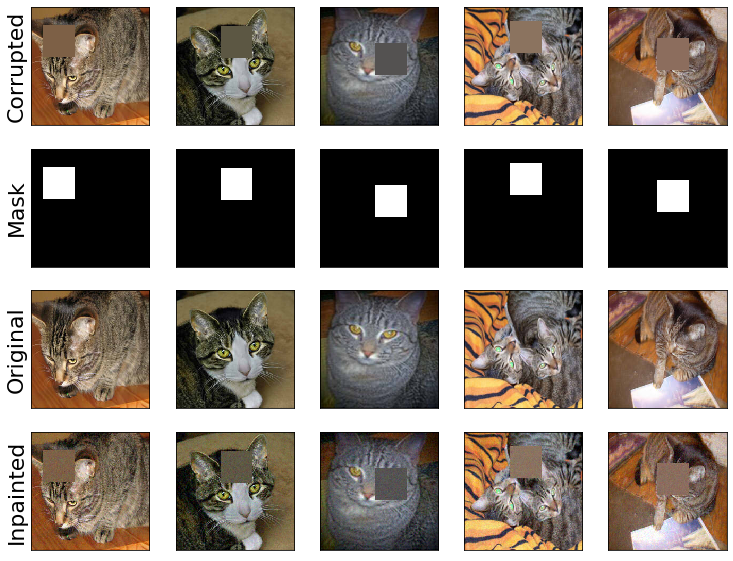

In [24]:
from robustness.tools.vis_tools import show_image_row, show_image_column
# Visualize inpainted images
show_image_row([img_corrupt.cpu(),mask.cpu(), img_orig.cpu(), img_inpaint.detach().cpu()], 
               ["Corrupted","Mask", "Original", "Inpainted"],
               fontsize=22)

In [7]:
STEPS = {
    'inf': LinfStep,
    '2': L2Step,
    'unconstrained': UnconstrainedStep
}

class experimentalModel(ch.nn.Module):
    def __init__(self, model, dataset):
        super(experimentalModel, self).__init__()
        self.normalizer = InputNormalize(dataset.mean, dataset.std)
        self.model = model
        self.attacker = infill_model(model, dataset)

    def forward(self, inp, target=None, make_adv=False, with_latent=False,
                    fake_relu=False, with_image=True, **attacker_kwargs):

        assert target is not None

        self.eval()
        adv = self.attacker(inp, target, **attacker_kwargs)

        inp = adv
#         if with_image:
#             normalized_inp = self.normalizer(inp)
#             output = self.model(normalized_inp, with_latent=with_latent,
#                                                     fake_relu=fake_relu)
#         else:
#             output = None

        return inp
    
class infill_model(ch.nn.Module):
    def __init__(self, model, dataset):
        super(infill_model, self).__init__()
        self.dataset = dataset
        self.model = model
        self.normalizer = InputNormalize(dataset.mean, dataset.std)
        
    def forward(self, x, target, *_, constraint, eps, step_size, iterations,
                random_start=False, random_restarts=False, do_tqdm=True,
                targeted=False, custom_loss=None, should_normalize=True, 
                orig_input=None, use_best=True):
                # Can provide a different input to make the feasible set around
        # instead of the initial point
        if orig_input is None: 
            orig_input = x.detach()
#             print("isNone")
        orig_input = orig_input.cuda()

        # Multiplier for gradient ascent [untargeted] or descent [targeted]
        m = -1 if targeted else 1

        # Initialize step class
        step = STEPS[constraint](eps=eps, orig_input=orig_input, step_size=step_size)

        def calc_loss(inp, target):
            '''
            Calculates the loss of an input with respect to target labels
            Uses custom loss (if provided) otherwise the criterion
            '''
#             if should_normalize:
#                 inp = self.normalize(inp)
            output = self.model(inp)

            return custom_loss(self.model, inp, target)

#             return criterion(output, target), output

        # Main function for making adversarial examples
        def get_adv_examples(x):
            # Random start (to escape certain types of gradient masking)
            if random_start:
                x = ch.clamp(x + step.random_perturb(x), 0, 1)

            iterator = range(iterations)
            if do_tqdm: iterator = tqdm(iterator)

            # Keep track of the "best" (worst-case) loss and its
            # corresponding input
            best_loss = None
            best_x = None

            # A function that updates the best loss and best input
            def replace_best(loss, bloss, x, bx):
                if bloss is None:
                    bx = x.clone().detach()
                    bloss = losses.clone().detach()
                else:
                    replace = m * bloss < m * loss
                    bx[replace] = x[replace].clone().detach()
                    bloss[replace] = loss[replace]

                return bloss, bx

            # PGD iterates    
            for _ in iterator:
                x = x.clone().detach().requires_grad_(True)
                losses,_ = calc_loss(x, target)
                assert losses.shape[0] == x.shape[0], 'Shape of losses must match input!'

                loss = ch.mean(losses)
                grad, = ch.autograd.grad(loss, [x])

                with ch.no_grad():
                    args = [losses, best_loss, x, best_x]
                    best_loss, best_x = replace_best(*args) if use_best else (losses, x)

                    x = step.make_step(grad) * m + x
                    x = ch.clamp(x, 0, 1)
                    x = step.project(x)
                    if do_tqdm: iterator.set_description("Current loss: {l}".format(l=loss))

            # Save computation (don't compute last loss) if not use_best
            if not use_best: return x.clone().detach()

            losses,_ = calc_loss(x, target)
            args = [losses, best_loss, x, best_x]
            best_loss, best_x = replace_best(*args)
            return best_x

        # Random restarts: repeat the attack and find the worst-case
        # example for each input in the batch
        if random_restarts:
            to_ret = None

            orig_cpy = x.clone().detach()
            for _ in range(random_restarts):
                adv = get_adv_examples(orig_cpy)

                if to_ret is None:
                    to_ret = adv.detach()

                _, output = calc_loss(adv, target)
                corr, = helpers.accuracy(output, target, topk=(1,), exact=True)
                corr = corr.byte()
                misclass = ~corr
                to_ret[misclass] = adv[misclass]

            adv_ret = to_ret
        else:
            adv_ret = get_adv_examples(x)

        return adv_ret
    
def do_infill(classifier, dataset, inp, target=None,**attacker_kwargs):
    model = infill_model(classifier, dataset)
    
    model = ch.nn.DataParallel(model)
    model.cuda()
    
    assert target is not None
    adv = model(inp, target, **attacker_kwargs)
    
    print("out")
    return adv


In [11]:
# PGD parameters
kwargs = {
        'constraint':'2',
        'eps': 21.6,
        'step_size': 0.1,
#         'iterations': 720, 
        'iterations': 150, 
        'do_tqdm': True,
        'targeted': True,
        'should_normalize': False
}

    
classifier, attacker = load_model(dataset, './models/{DATA}.pt')

# Inpainting using PGD
_, (img_orig, targ_orig) = next(data_iterator)
img_corrupt, mask = mask_image(img_orig.clone())

kwargs['custom_loss'] = inpainting_loss_wrapper(img_corrupt.cuda(), 
                                            mask.cuda(), 
                                            InputNormalize(dataset.mean, dataset.std).cuda())

outputs = do_infill(classifier, dataset,img_corrupt, targ_orig.clone(), **kwargs)


out


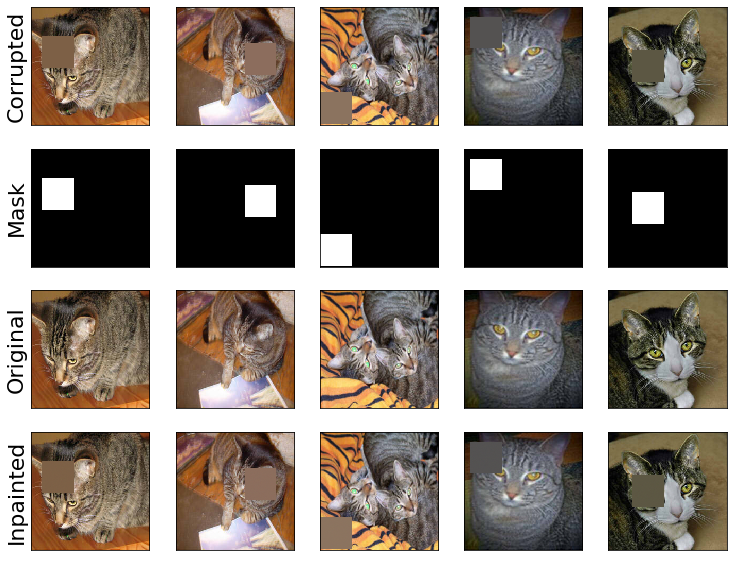

In [12]:
from robustness.tools.vis_tools import show_image_row, show_image_column
# Visualize inpainted images
show_image_row([img_corrupt.cpu(),mask.cpu(), img_orig.cpu(), outputs.detach().cpu()], 
               ["Corrupted","Mask", "Original", "Inpainted"],
               fontsize=22)